# Задание 1. SHAP и коррелированные табличные данные

Изучите коррелированность вещественных признаков для датасета [AqSolDB](https://www.nature.com/articles/s41597-019-0151-1), объединяющего информацию о растворимости химических веществ из разных источников.

Обучите линейную регрессию и оцените важность вещественных признаков, используя веса перед ними.

Обучите градиентный бустинг из библиотеки XGBoost для вещественных признаков.

Визуализируйте важность вещественных признаков в XGBoost, используя SHAP.




## Формат результата

В результате выполнения задания необходимо получить:
* таблицу с оценкой важности признаков с помощью их весов в линейной регрессии,
* таблицу важности признаков для XGBoost,
* SHAP визуализацию важности признаков XGBoost.

Примеры визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/result_1_1_task_ex14.png"  width="500">
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/result_2_1_task_ex14.png"  width="500">

## Коррелированность вещественных признаков

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Загрузка датасета:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/curated-solubility-dataset.csv

data = pd.read_csv("curated-solubility-dataset.csv")
data.head()

ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   -3.616127  0.0   
1                               O=C1Nc2cccc3cccc1c23   -3.254767  0.0   
2                                    Clc1ccc(C=O)cc1   -2.177078  0.0   
3  [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...   -3.924409  0.0   
4  C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...   -4.662065  0.0   

   Ocurrences Group    MolWt  ...  NumRotatableBonds  NumValenceElectrons  \
0           1    G1  392.510  ...               17.0                142.0   
1           1    G1  169.183  ...                0.0                 62.0   
2           1    G1  140.569  ...                1.0                 46.0   
3           1    G1  756.226  ...               10.0                264.0   
4           1    G1  422.525  ...               12.0                164.0   

   NumAromaticRings  NumSaturatedRings  NumAliphaticRings  RingCount    TPSA  \
0               0.0                0.0                0.0        0.0    0.00   
1               2.0                0.0                1.0        3.0   29.10   
2               1.0                0.0                0.0        1.0   17.07   
3               6.0                0.0                0.0        6.0  120.72   
4               2.0                4.0                4.0        6.0   56.60   

    LabuteASA      BalabanJ      BertzCT  
0  158.520601  0.000000e+00   210.377334  
1   75.183563  2.582996e+00   511.229248  
2   58.261134  3.009782e+00   202.661065  
3  323.755434  2.322963e-07  1964.648666  
4  183.183268  1.084427e+00   769.899934  

[5 rows x 26 columns]

Для обучения будем пользоваться только вещественными признаками. Целевой переменной будет Solubility (растворимость).

In [ ]:
features = data.loc[:, "MolWt":]
target = data["Solubility"]

Разбиение данных на обучающую и тестовую выборки:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Ознакомьтесь с матрицей корреляции вещественных признаков.

In [ ]:
corr = x_train.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(cmap, axis=1).format(precision=3)

Найдем для каждого признака тот, с которым у него максимальная корреляция:

In [ ]:
corr_np = corr.to_numpy()
np.fill_diagonal(corr_np, 0)  # remove self correlations 1 -> 0

max_corr_ids = np.argmax(np.abs(corr_np), axis=1)  # find index of max corr. feature
max_corr_feature = x_train.columns[max_corr_ids]

max_corr_value = np.max(np.abs(corr_np), axis=1)


max_correlations = pd.DataFrame(
    {"feature": x_train.columns,
     "max_corr_feature": max_corr_feature,
     "abs_corrcoef": max_corr_value}
)
max_correlations

feature     max_corr_feature  abs_corrcoef
0                 MolWt            LabuteASA      0.971521
1               MolLogP                MolMR      0.500434
2                 MolMR  NumValenceElectrons      0.976358
3        HeavyAtomCount  NumValenceElectrons      0.993122
4         NumHAcceptors       NumHeteroatoms      0.898048
5            NumHDonors                 TPSA      0.610531
6        NumHeteroatoms        NumHAcceptors      0.898048
7     NumRotatableBonds  NumValenceElectrons      0.717779
8   NumValenceElectrons       HeavyAtomCount      0.993122
9      NumAromaticRings              BertzCT      0.829284
10    NumSaturatedRings    NumAliphaticRings      0.896532
11    NumAliphaticRings    NumSaturatedRings      0.896532
12            RingCount              BertzCT      0.810546
13                 TPSA       NumHeteroatoms      0.897068
14            LabuteASA       HeavyAtomCount      0.983559
15             BalabanJ            LabuteASA      0.378659
16              BertzCT       HeavyAtomCount      0.901921

## Линейная регрессия для вещественных признаков

Обучите модель линейной регрессии [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) на вещественных признаках датасета. **Не забудьте стандартизовать данные!**

In [ ]:
ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(x_train_ss, y_train)
# Your code here

LinearRegression()

Для линейной регрессии в качестве меры важности признаков могут использоваться веса перед ними.

In [ ]:
linear_importance = pd.DataFrame(
    {"feature": x_train.columns, "linreg_coef": model_lr.coef_}
)

importance = max_correlations.merge(linear_importance, on="feature")
importance.sort_values(by="linreg_coef", ascending=False)

feature     max_corr_feature  abs_corrcoef  linreg_coef
8   NumValenceElectrons       HeavyAtomCount      0.993122     4.809274
16              BertzCT       HeavyAtomCount      0.901921     2.603915
2                 MolMR  NumValenceElectrons      0.976358     1.140097
4         NumHAcceptors       NumHeteroatoms      0.898048     0.535803
7     NumRotatableBonds  NumValenceElectrons      0.717779     0.315525
5            NumHDonors                 TPSA      0.610531     0.215981
10    NumSaturatedRings    NumAliphaticRings      0.896532     0.143248
15             BalabanJ            LabuteASA      0.378659    -0.025318
13                 TPSA       NumHeteroatoms      0.897068    -0.075147
11    NumAliphaticRings    NumSaturatedRings      0.896532    -0.078921
12            RingCount              BertzCT      0.810546    -0.449027
9      NumAromaticRings              BertzCT      0.829284    -0.493917
6        NumHeteroatoms        NumHAcceptors      0.898048    -0.739342
14            LabuteASA       HeavyAtomCount      0.983559    -0.742702
0                 MolWt            LabuteASA      0.971521    -0.758080
1               MolLogP                MolMR      0.500434    -1.536503
3        HeavyAtomCount  NumValenceElectrons      0.993122    -6.595637

**Напишите вывод:**
Вывод


## XGBoost для вещественных признаков

Обучите градиентный бустинг из библиотеки XGBoost:

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.3)
model_xgb.fit(x_train, y_train)
# Your code here

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Извлеките [важности признаков](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor.feature_importances_) обученной модели и добавьте их в таблицу `importance`.

In [ ]:
# Your code here
xgbr_importance = pd.DataFrame(
    {"feature": x_train.columns, "xgb_feat_imp": model_xgb.feature_importances_}
)

In [ ]:
importance = importance.merge(xgbr_importance, on="feature")
importance.sort_values(by="xgb_feat_imp", ascending=False)

feature     max_corr_feature  abs_corrcoef  linreg_coef  \
1               MolLogP                MolMR      0.500434    -1.536503   
16              BertzCT       HeavyAtomCount      0.901921     2.603915   
2                 MolMR  NumValenceElectrons      0.976358     1.140097   
0                 MolWt            LabuteASA      0.971521    -0.758080   
6        NumHeteroatoms        NumHAcceptors      0.898048    -0.739342   
13                 TPSA       NumHeteroatoms      0.897068    -0.075147   
15             BalabanJ            LabuteASA      0.378659    -0.025318   
7     NumRotatableBonds  NumValenceElectrons      0.717779     0.315525   
8   NumValenceElectrons       HeavyAtomCount      0.993122     4.809274   
4         NumHAcceptors       NumHeteroatoms      0.898048     0.535803   
14            LabuteASA       HeavyAtomCount      0.983559    -0.742702   
5            NumHDonors                 TPSA      0.610531     0.215981   
11    NumAliphaticRings    NumSaturatedRings      0.896532    -0.078921   
3        HeavyAtomCount  NumValenceElectrons      0.993122    -6.595637   
9      NumAromaticRings              BertzCT      0.829284    -0.493917   
12            RingCount              BertzCT      0.810546    -0.449027   
10    NumSaturatedRings    NumAliphaticRings      0.896532     0.143248   

    xgb_feat_imp  
1       0.516290  
16      0.060991  
2       0.037083  
0       0.035989  
6       0.035423  
13      0.034495  
15      0.034461  
7       0.032429  
8       0.031873  
4       0.027731  
14      0.027023  
5       0.026962  
11      0.022487  
3       0.022353  
9       0.021007  
12      0.019343  
10      0.014061

Сравните важности признаков для линейной регрессии и XGBoost. Как они связаны с корреляцией? Какая оценка важности адекватнее? Почему?

Особой связи важности признаков и корреляции не наблюдается, как мне кажется, адекватнее оценка XGBoost, т.к. при таком количестве признаков линейная модель может работать хуже.

## Визуализация SHAP для вещественных признаков

Выведите предсказание модели градиентного бустинга для одного объекта обучающей выборки с помощью метода `predict`.

In [ ]:
sample_idx = 285 # Your value here
sample = x_train.iloc[[sample_idx]]
sample

MolWt  MolLogP    MolMR  HeavyAtomCount  NumHAcceptors  NumHDonors  \
5300  173.256   1.0637  48.8325            12.0            2.0         2.0   

      NumHeteroatoms  NumRotatableBonds  NumValenceElectrons  \
5300             3.0                6.0                 72.0   

      NumAromaticRings  NumSaturatedRings  NumAliphaticRings  RingCount  \
5300               0.0                0.0                0.0        0.0   

       TPSA  LabuteASA  BalabanJ     BertzCT  
5300  49.33  74.164406  3.143238  123.696943

In [ ]:
prediction = model_xgb.predict(sample)  # Your code here

print(f"XGB prediction for sample #{sample_idx}: {prediction[0]:.3f}")

XGB prediction for sample #285: -0.596


In [ ]:
!pip install rdkit-pypi
!pip install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.3 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [ ]:
data.iloc[5300]

ID                                                                B-2149
Name                                                   n-hexyl-lactamide
InChI                  InChI=1S/C9H19NO2/c1-3-4-5-6-7-10-9(12)8(2)11/...
InChIKey                                     RUUHGTZPDZPPOC-UHFFFAOYSA-N
SMILES                                                 CCCCCCNC(=O)C(C)O
Solubility                                                       -0.9487
SD                                                                   0.0
Ocurrences                                                             1
Group                                                                 G1
MolWt                                                            173.256
MolLogP                                                           1.0637
MolMR                                                            48.8325
HeavyAtomCount                                                      12.0
NumHAcceptors                                      

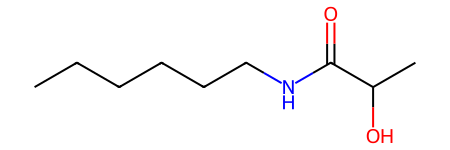

In [ ]:
mol = Chem.MolFromSmiles('CCCCCCNC(=O)C(C)O')
mol

Создайте SHAP-модель объяснения предсказаний для модели градиентного бустинга. Используйте [`shap.TreeExplainer`](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html).

Передайте SHAP-модели входные данные из обучающей выборки и получите для них SHAP-объяснения.

In [ ]:
explainer = shap.TreeExplainer(model_xgb) # Your code here

explanations = explainer(x_train) # Your code here

Посмотрите, из чего состоит объяснение для одного объекта

In [ ]:
explanation_sample = explanations[sample_idx]
explanation_sample

.values =
array([ 0.09953355,  1.3256052 ,  0.11101639,  0.02858052,  0.02224324,
        0.07784358, -0.02985998,  0.04373178, -0.07583334, -0.02493251,
       -0.0187532 ,  0.0135273 ,  0.00469539,  0.1267878 ,  0.10255401,
        0.00247881,  0.4784647 ], dtype=float32)

.base_values =
-2.8839693

.data =
array([173.256     ,   1.0637    ,  48.8325    ,  12.        ,
         2.        ,   2.        ,   3.        ,   6.        ,
        72.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  49.33      ,  74.16440598,   3.1432375 ,
       123.69694286])

Убедитесь, что сумма SHAP-значений для признаков вместе с базовым значением дает предсказание модели.

In [ ]:
shap_values_sum = explanation_sample.values.sum() + explanation_sample.base_values
shap_values_sum

-0.59628606

In [ ]:
  # Your code here
print(f"Sum of shap values for sample #{sample_idx}: {shap_values_sum:.3f}")
print(f"XGB prediction for sample #{sample_idx}: {prediction[0]:.3f}")

assert np.allclose(shap_values_sum, prediction), "Oops, something wrong! Look here: https://clck.ru/9TFat"
print("Good work! This is for you: https://clck.ru/38ZE8r")

Sum of shap values for sample #285: -0.596
XGB prediction for sample #285: -0.596
Good work! This is for you: https://clck.ru/38ZE8r


Объясните предсказание модели градиентного бустинга для данного объекта из обучающей выборки  при помощи [`shap.plots.force`](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html#shap-plots-force). Перед построением визуализации не забудьте вызвать `shap.initjs()`.

In [ ]:
# Your code here
# Use shap.plots.force
shap.initjs()
# visualize the first prediction’s explanation
shap.plots.force(base_value=explanation_sample.base_values, shap_values=explanation_sample.values, feature_names=x_train.columns)

Объясните предсказание для этого же объекта при помощи [`shap.plots.waterfall`](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html?highlight=waterfall).

In [ ]:
explanation_sample

.values =
array([ 0.09953355,  1.3256052 ,  0.11101639,  0.02858052,  0.02224324,
        0.07784358, -0.02985998,  0.04373178, -0.07583334, -0.02493251,
       -0.0187532 ,  0.0135273 ,  0.00469539,  0.1267878 ,  0.10255401,
        0.00247881,  0.4784647 ], dtype=float32)

.base_values =
-2.8839693

.data =
array([173.256     ,   1.0637    ,  48.8325    ,  12.        ,
         2.        ,   2.        ,   3.        ,   6.        ,
        72.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  49.33      ,  74.16440598,   3.1432375 ,
       123.69694286])

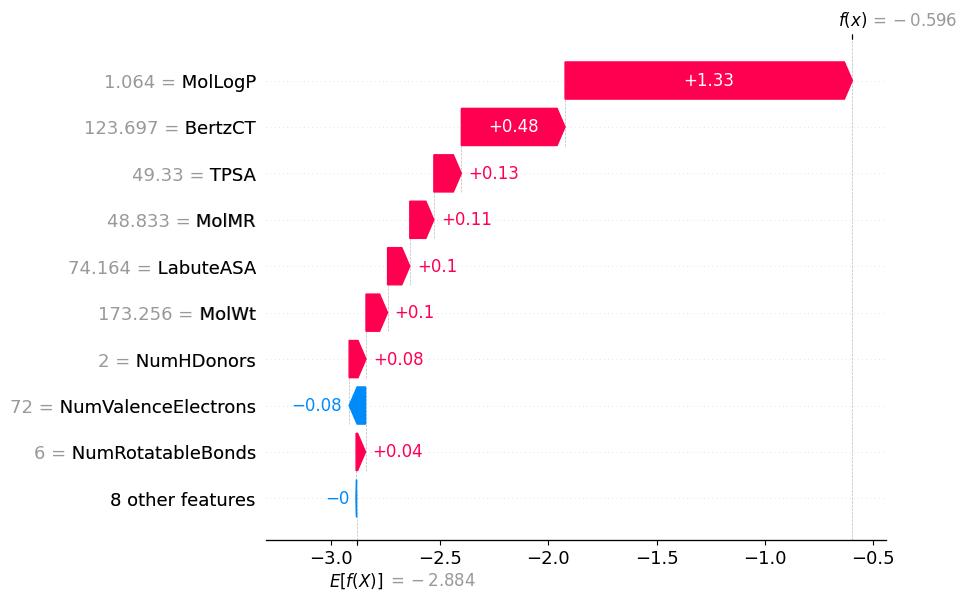

In [ ]:
# Your code here
# Use shap.plots.waterfall
# visualize the first prediction's explanation using waterfall
shap.plots.waterfall(explanation_sample)

Посмотрите на важность признаков в целом, используя [`shap.plots.bar`](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html), [`shap.plots.beeswarm`](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html?highlight=beeswarm#A-simple-beeswarm-summary-plot) и [`shap.plots.violin`](https://shap.readthedocs.io/en/latest/generated/shap.plots.violin.html#shap-plots-violin).

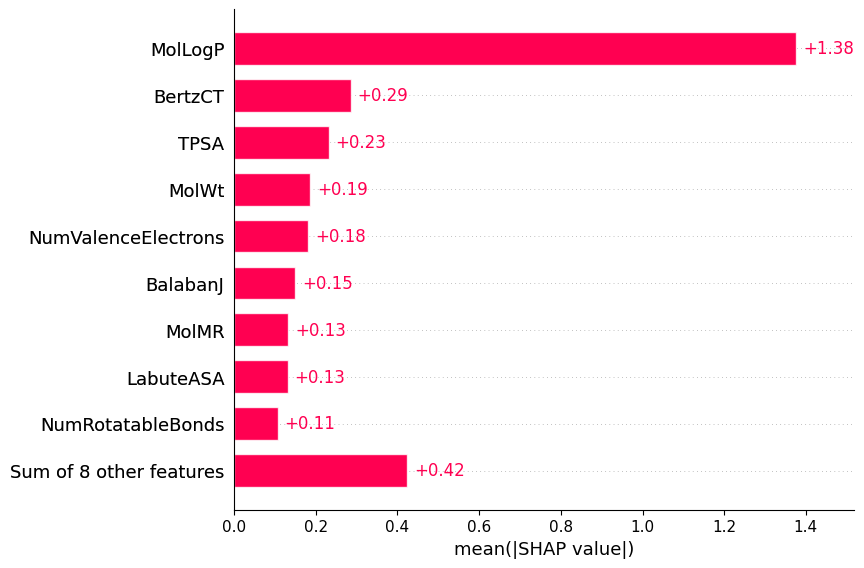

In [ ]:
# Your code here
# shap.plots.bar
shap.plots.bar(explanations)

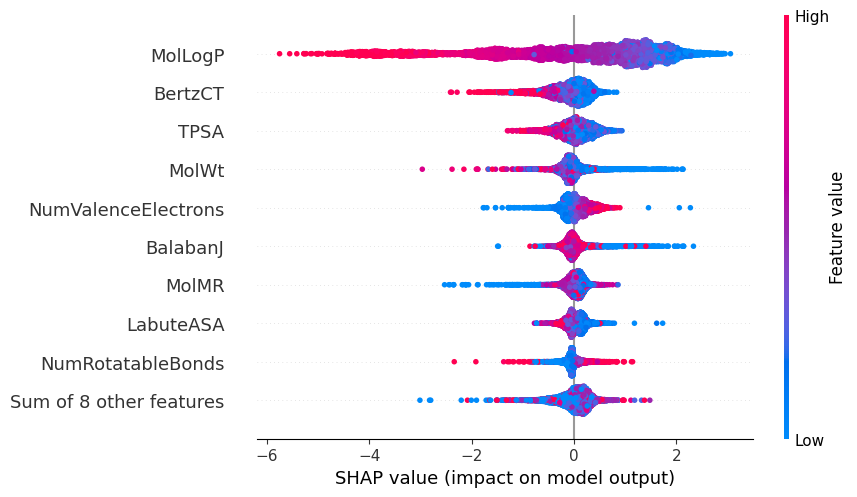

In [ ]:
# Your code here
# shap.plots.beeswarm
shap.plots.beeswarm(explanations)

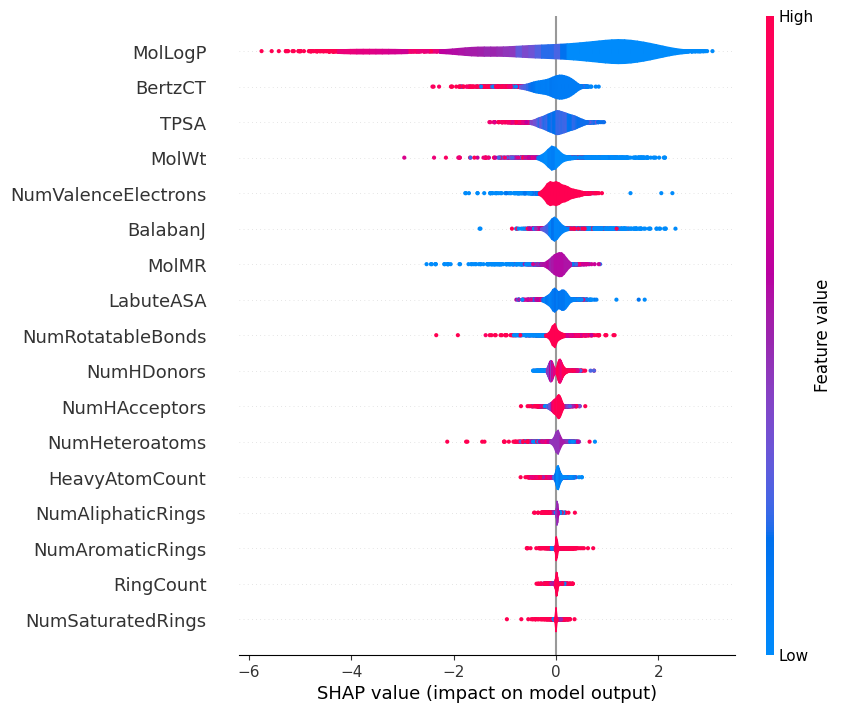

In [ ]:
# Your code here
# shap.plots.violin
shap.plots.violin(explanations)

Постройте waterfall-объяснение предсказания для молекулы из **тестовой** выборки, для которой предсказано наименьшее значение Solubility:

In [ ]:
# Your code here
predictions = model_xgb.predict(x_test)

In [ ]:
predictions.argmin()

177

In [ ]:
x_test.iloc[177]

MolWt                  514.661000
MolLogP                 10.012900
MolMR                  103.058000
HeavyAtomCount          23.000000
NumHAcceptors            1.000000
NumHDonors               0.000000
NumHeteroatoms          11.000000
NumRotatableBonds        2.000000
NumValenceElectrons    124.000000
NumAromaticRings         2.000000
NumSaturatedRings        0.000000
NumAliphaticRings        0.000000
RingCount                2.000000
TPSA                     9.230000
LabuteASA              180.634705
BalabanJ                 2.712767
BertzCT                690.954533
Name: 9875, dtype: float64

In [ ]:
data.iloc[9875]['SMILES']

'ClC1=C(Cl)C(Cl)=C(OC2=C(Cl)C(Cl)=C(Cl)C(Cl)=C2Cl)C(Cl)=C1Cl'

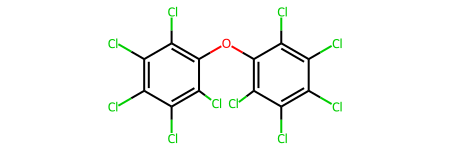

In [ ]:
mol_test = Chem.MolFromSmiles('ClC1=C(Cl)C(Cl)=C(OC2=C(Cl)C(Cl)=C(Cl)C(Cl)=C2Cl)C(Cl)=C1Cl')
mol_test

In [ ]:
explanations_test = explainer(x_test) # Your code here

In [ ]:
explanation_sample_test = explanations_test[177]
explanation_sample_test

.values =
array([-3.4486163e-01, -5.5257897e+00, -1.9769867e-01,  2.8936693e-02,
        5.2327458e-02, -1.0726270e-01, -6.4473468e-01, -2.3106557e-01,
        1.4397979e-01, -1.2514996e-02,  1.3402021e-02,  5.4216450e-03,
       -5.4189260e-03, -3.2734609e-01, -1.6662547e-01, -2.3226964e-01,
       -5.8343804e-01], dtype=float32)

.base_values =
-2.8839693

.data =
array([514.661     ,  10.0129    , 103.058     ,  23.        ,
         1.        ,   0.        ,  11.        ,   2.        ,
       124.        ,   2.        ,   0.        ,   0.        ,
         2.        ,   9.23      , 180.63470482,   2.7127674 ,
       690.95453308])

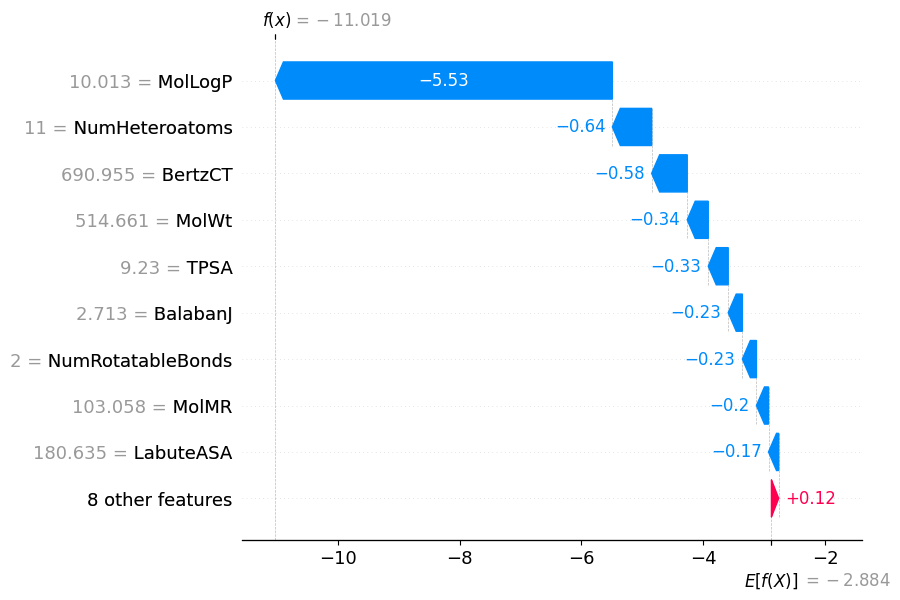

In [ ]:
shap.plots.waterfall(explanation_sample_test)

Сравните результаты оценки признаков с помощью
`xgb.feature_importances_` и SHAP. **Напишите вывод:**

Результаты очень похожи. Как мы видим на примере самой плохорастворимой молекулы, SHAP адекватно дает оценку важности признаков - большое значение logP (липофильности) вносит самый большой вклад в оценку растворимости. Структура соединения действительно говорит о том, что оно будет невероятно плохо растворяться в воде.




# Задание 2. SHAP. NLP: Классификация эмоциональной окраски отзывов

Дана NLP модель: трансформер, обученный на задаче предсказания эмоциональной окраски ("POSITIVE"/"NEGATIVE") отзыва.

Изучите результат работы модели с помощью SHAP:
* Ознакомьтесь с работой `tokenizer`, форматом входных данных и результатом работы модели
* Ознакомьтесь с форматом выдачи SHAP
* Напишите функцию, рассчитывающую предсказанные моделью вероятности классов, используя выдачу SHAP для одного объекта
* Напишите функцию для визуализации объяснения предсказания модели для класса "POSITIVE"
* Выберите отзывы с IMDb и визуализируйте предсказания для них

## Формат результата

Результатом работы является:
* функция `shap_val_to_pred(shap_val)`, рассчитывающая предсказанные моделью вероятности классов, используя выдачу SHAP. Результат выполнения тестового блока должен выглядеть так:

```
examples[0]: OK
examples[1]: OK
examples[2]: OK
examples[3]: OK
```
* визуализация важности признаков с помощью [shap.plots.text](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html)

Пример визуализации:
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/result_2_task_ex14.png" width="1000">

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q shap
!pip install -q transformers

In [ ]:
import math
import shap
import torch
import transformers
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
)

In [ ]:
torch.manual_seed(42)

## Tokenizer и модель

Загрузка tokenizer (предобрабатывает предложения прежде чем подать их в модель):

In [ ]:
from warnings import simplefilter

simplefilter("ignore", UserWarning)

tokenizer_name = "distilbert-base-uncased"
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Работа tokenizer:

In [ ]:
print(tokenizer.tokenize("I'll be back"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I'll be back")))
print(tokenizer.encode("I'll be back"))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("I'll be back")))

['i', "'", 'll', 'be', 'back']
[1045, 1005, 2222, 2022, 2067]
[101, 1045, 1005, 2222, 2022, 2067, 102]
['[CLS]', 'i', "'", 'll', 'be', 'back', '[SEP]']


`[CLS]` и `[SEP]` — специальные токены. Подробнее о специальных токенах можно почитать по [ссылке](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.sep_token).

In [ ]:
dict(zip(tokenizer.all_special_ids, tokenizer.all_special_tokens))

{100: '[UNK]', 102: '[SEP]', 0: '[PAD]', 101: '[CLS]', 103: '[MASK]'}

Загрузка трансформера, обученного на задаче предсказания позитивности/негативности отзыва:

In [ ]:
device = "cpu"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).to(
    device
)

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Пример работы модели:

In [ ]:
examples = ["example", "example two", "example three the best", "professionalism"]
prediction = classifier(examples)
prediction

[[{'label': 'POSITIVE', 'score': 0.968960165977478},
  {'label': 'NEGATIVE', 'score': 0.03103986382484436}],
 [{'label': 'POSITIVE', 'score': 0.976680338382721},
  {'label': 'NEGATIVE', 'score': 0.023319678381085396}],
 [{'label': 'POSITIVE', 'score': 0.9998076558113098},
  {'label': 'NEGATIVE', 'score': 0.000192355495528318}],
 [{'label': 'POSITIVE', 'score': 0.9986911416053772},
  {'label': 'NEGATIVE', 'score': 0.0013089036801829934}]]

Форматируем выход: приводим в формат вида `list[dict{'NEGATIVE': val, 'POSITIVE': val},...]` с точностью значений 5 знаков после запятой.

In [ ]:
model_prediction = [
    {
        item[0]["label"]: round(item[0]["score"], 5),
        item[1]["label"]: round(item[1]["score"], 5),
    }
    for item in prediction
]
print(*model_prediction, sep="\n")

{'POSITIVE': 0.96896, 'NEGATIVE': 0.03104}
{'POSITIVE': 0.97668, 'NEGATIVE': 0.02332}
{'POSITIVE': 0.99981, 'NEGATIVE': 0.00019}
{'POSITIVE': 0.99869, 'NEGATIVE': 0.00131}


##  Построение SHAP-объяснений

In [ ]:
explainer = shap.Explainer(classifier)
shap_vals = explainer(examples)

PartitionExplainer explainer: 5it [00:12,  6.09s/it]


Результат работы SHAP для примера с индексом `1` (`"example two"`):

In [ ]:
shap_vals[1]

.values =
array([[ 0.        ,  0.        ],
       [-0.10315985,  0.1031599 ],
       [-0.14678595,  0.14678591],
       [ 0.        ,  0.        ]])

.base_values =
array([0.27326548, 0.72673452])

.data =
array(['', 'example ', 'two', ''], dtype='<U8')

Устройство объекта с объяснениями для одного примера:

* `shap_vals[idx].values` — массив размером `(количество токенов, количество классов)` — SHAP-значения для каждого токена при предсказании каждого класса

* `shap_vals[idx].base_values` — массив размером `(количество классов,)` — базовые предсказания для каждого класса

* `shap_vals[idx].data` — объясняемые данные (в данном случае содержит список токенов)

Объяснения для примера с индексом `1` для класса `"POSITIVE"`:

In [ ]:
shap_vals[1, :, "POSITIVE"]

.values =
array([0.        , 0.1031599 , 0.14678591, 0.        ])

.base_values =
0.7267345190048218

.data =
array(['', 'example ', 'two', ''], dtype='<U8')

Важным свойством [чисел Шепли](https://arxiv.org/abs/1705.07874) (`shap_vals`) является то, что их сумма, сложенная с неким базовым значением, должна совпасть с предсказанием модели:

$$  f(x) = \phi_0 + \sum_{i=1}^{M} \phi_i,$$

где:

$f(x)$ — предсказание модели,

$\phi_0$ — базовое значение,

$M$ — число признаков,

$\phi_i$ — число Шепли, объясняющее i-й признак.


Напишите функцию, которая рассчитывает предсказанные моделью вероятности
классов 'NEGATIVE' и 'POSITIVE' **для одного объекта**. Формат вывода `dict{'NEGATIVE': val, 'POSITIVE': val}` с точностью значений 5 знаков после запятой.

In [ ]:
def shap_val_to_pred(shap_val):
    # Your code here
    pos = 0
    neg = 0
    for i in range(shap_val.shape[0]):
        pos += shap_val.values[i][1]
        neg += shap_val.values[i][0]# Your code here
    return {'POSITIVE': round(pos + shap_val.base_values[1], 5),'NEGATIVE': round(neg + shap_val.base_values[0], 5)}

Тестовый блок:

In [ ]:
for i in range(len(shap_vals)):
    try:
        assert model_prediction[i] == shap_val_to_pred(shap_vals[i])
    except AssertionError:
        print(f"""examples[{i}]: Error, sum of shap values not equal to pred!
             pred: {model_prediction[i]} shap sum {shap_val_to_pred(shap_vals[i])}""")
    else:
        print(f"examples[{i}]: OK")

examples[0]: OK
examples[1]: OK
examples[2]: OK
examples[3]: OK


## Визуализация SHAP

Напишите функцию для визуализации объяснения предсказания модели с использованием [`shap.plots.text`](https://shap.readthedocs.io/en/latest/generated/shap.plots.text.html#shap-plots-text). Перед построением визуализации не забудьте вызвать `shap.initjs()`.

In [ ]:
def score_and_visualize(model, text):
    # Your code here
    explainer = shap.Explainer(classifier)
    explanation = explainer(text)
    shap.plots.text(explanation)

Проверка работы функции:

In [ ]:
score_and_visualize(classifier, ["example three the best"])

Выберите какие-то сериалы/фильмы, которые вам особо нравятся/не нравятся. Возьмите с сайта [IMDb](https://www.imdb.com/) один позитивный и один негативный отзыв.

Визуализируйте предсказание модели с помощью функции `score_and_visualize`.

In [ ]:
# Your code here
text_rew_pos = [
    "With the exception of the bad chinese (maybe that's also intentional, who knows), Amanda Seyfried is great at portraying Elizabeth Holmes. She looked like her, she got the weird and awkward manner, the deepen of the voice. You look at her and think that she is Elizabeth Holmes"
]
shap.initjs()
score_and_visualize(model, text_rew_pos)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:53, 53.21s/it]               


In [ ]:
text_rew_neg = [
    "Amanda Seyfried did a good job but the show was terrible, stopped watching after episode three. Way too much embellishment in story. Soulless cinematography like everything put out by streaming services. Typical entertainment industry misandry. All men bad, all women perfect at all times. White men must looks weak or evil at all times"
]
shap.initjs()
score_and_visualize(model, text_rew_neg)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.63s/it]               


На какие словосочетания модель больше всего реагирует? Согласны ли вы с ее вердиктом?

**Напишите вывод:**

Модель реагирует на слова, дающие оценку или характеристику, в основном на прилагательные (что логично). Например, great, bad, awkward, terrible, perfect, weak, evil. Интересно, что в положительном отзыве часть предложения "she got the weird and awkward manner" воспринимается моделью как негативная оценка, хотя по контексту понятно, что это похвала актрисе за воспроизведение манер реального человека. То есть модель оценивает отдельные токены без учета контекста (либо контекста не хватило). С вердиктом согласен.

# Задание 3. GradCAM для FashionMNIST

В этом задании от вас требуется получить и визуализировать GradCAM-карты активаций для сверточной нейронной сети, обученной на датасете FashionMNIST.

## Формат результата

В результате должна получиться визуализация для десяти изображений разных классов. Для каждого изображения требуется определить предсказанный моделью класс и визуализировать карты активаций для всех классов.

Пример визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/result_1_3_task_ex14.png" width="600">

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q grad-cam
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.4 MB/s eta 0:00:00


In [ ]:
import torch
import random
import numpy as np
import torchmetrics
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torchsummary import summary
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from torch.utils.data import DataLoader
from IPython.display import clear_output
from torchvision.datasets import FashionMNIST
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## Загрузка датасета

In [ ]:
train_data= FashionMNIST("FashionMNIST", train=True, download=True, transform=transforms.ToTensor())
test_data = FashionMNIST("FashionMNIST", train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()

## Загрузка модели

Обученная модель имеет следующую архитектуру:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (-1, 32, 14, 14)
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (-1, 64, 7, 7)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

Скачаем обученные веса и загрузим их в модель:

In [ ]:
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/ex14_task3_model_weights.pth

In [ ]:
model = ConvNet()
model.load_state_dict(torch.load("ex14_task3_model_weights.pth"))

<All keys matched successfully>

Посмотрим на размерности выходов слоев:

In [ ]:
from torchsummary import summary

summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
           Flatten-4                 [-1, 3136]               0
            Linear-5                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.19
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


Убедимся, что модель обучена:

In [ ]:
import torchmetrics

num_classes = len(test_data.classes)

accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes)

for batch in test_loader:
    imgs, labels = batch

    pred = model(imgs)

    accuracy.update(pred, labels)

print(f"Trained model accuracy: {accuracy.compute():.1%}")

Trained model accuracy: 90.2%


## Выбор изображений для визуализации

Отберем из тестовой выборки 10 изображений: по одному случайному изображению каждого класса. Соберем их в тензор `images`.

In [ ]:
idx = []
for class_num in range(num_classes):
    # find indexes of all images of current class_num
    matched_idx = np.where(test_data.targets.numpy() == class_num)[0]
    # convert them to list
    matched_idx = matched_idx.tolist()

    # choice index of random image of current class_num
    idx.append(random.choice(matched_idx))

images = test_data.data[idx] / 255  # divide because we call raw .data without transform
images = images.unsqueeze(1)  # add channel dimension
print(images.shape)

torch.Size([10, 1, 28, 28])


Отобразим изображения и убедимся, что они отобрались верно:

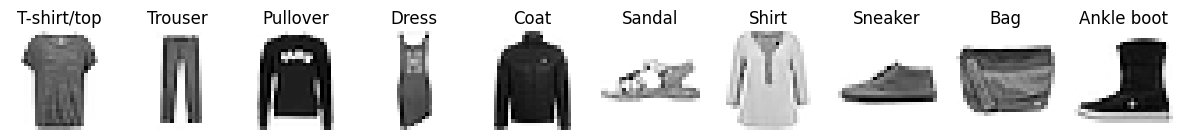

In [ ]:
plt.figure(figsize=(15, 3))

for i in range(num_classes):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(images[i].squeeze(), cmap="Greys")
    plt.axis("off")
    plt.title(test_data.classes[i])
plt.show()

## Получение GradCAM-карт активаций

Выведем внутреннее устройство модели. Карты активаций для GradCAM будем брать из последнего слоя `Conv2D` в сверточной части модели

In [ ]:
print(model)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)


In [ ]:
[model.conv_layers[2]]

[Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

In [ ]:
model._modules['conv_layers'][2]

Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

В `target_layers` укажите нужный модуль модели. Здесь `target_layers` — список из одного элемента.

Затем создайте объект `cam` как экземпляр класса `GradCAM`. При создании объекта передайте в конструктор класса модель и `target_layers`.

In [ ]:
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


target_layers = [model.conv_layers[2]] # Your code here

cam = GradCAM(model, target_layers) # Your code here

1. Возьмите одно изображение из тензора `images`. Оно должно иметь размер `(1, 1, 28, 28)`. Для согласованности с кодом лекции рекомендуется назвать его `img_t`.

2. Создайте numpy-аналог изображения для последущей визуализации. Размер массива должен быть `(28, 28)`. Для согласованности с кодом лекции рекомендуется назвать его `img_arr`.

3. Подайте тензор с изображением в модель, получите вектор предсказанных вероятностей классов `prediction` размером `(10,)`.

4. Определите номер и название самого вероятного класса, предсказанного моделью (`predicted_class` и `predicted_class_name`). Список названий классов можно взять в `test_data.classes`.



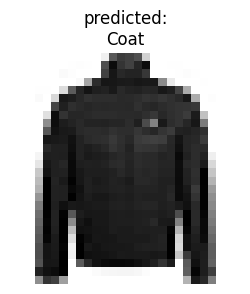

In [ ]:
# Your code here
img_t = images[4].unsqueeze(0)
img_arr = img_t.numpy().squeeze(0).squeeze(0)
prediction = torch.nn.functional.softmax(model(img_t), dim=1)
predicted_class = prediction.argmax()
predicted_class_name = test_data.classes[predicted_class]
# End of your code
plt.figure(figsize=(3, 3))
plt.imshow(img_arr, cmap="Greys")
plt.title(f"predicted:\n{predicted_class_name}")
plt.axis("off")
plt.show()

In [ ]:
prediction

tensor([[8.0143e-06, 7.6249e-09, 6.7550e-02, 1.1938e-08, 9.2995e-01, 4.5927e-12,
         2.4921e-03, 7.1770e-12, 4.3385e-07, 3.7802e-10]],
       grad_fn=<SoftmaxBackward0>)

Получите GradCAM-карту активаций для предсказанного (самого вероятного) класса для данного изображения. Размер карты активаций `cam_map` должен быть `(28, 28)` (без числа каналов).

In [ ]:
top_props, top_inds = prediction.topk(10)

In [ ]:
top_props

tensor([[9.2995e-01, 6.7550e-02, 2.4921e-03, 8.0143e-06, 4.3385e-07, 1.1938e-08,
         7.6249e-09, 3.7802e-10, 7.1770e-12, 4.5927e-12]],
       grad_fn=<TopkBackward0>)

In [ ]:
top_inds

tensor([[4, 2, 6, 0, 8, 3, 1, 9, 7, 5]])

cam_map.shape is (28, 28)


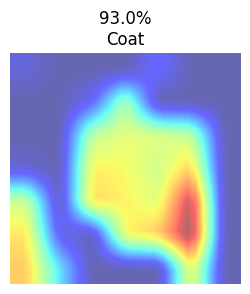

In [ ]:
target = [ClassifierOutputTarget(top_inds[0][0])] # Your code here
cam_map = cam(input_tensor=img_t, targets=target).squeeze(0) # Your code here

assert cam_map.shape == (28, 28), f"cam_map.shape is {cam_map.shape}. Please remove channel dimension"

# Nothing to change here
print(f"cam_map.shape is {cam_map.shape}")
plt.figure(figsize=(3, 3))
plt.imshow(
    cam_map,
    alpha=0.6,
    interpolation="bilinear",
    cmap="jet",
    )
plt.title(f"{prediction[0][predicted_class].item():.1%}\n{test_data.classes[predicted_class]}")
plt.axis("off")
plt.show()

Теперь получите и отобразите карты активаций для всех классов для данного одного изображения.

Предлагается воспользоваться `plt.subplot(1, num_classes + 1)`. Сначала выведите оригинальное изображение на первом `subplot`, а затем в цикле по классам получите и выведите карты активаций для всех классов. Формат визуализации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/result_2_3_task_ex14.png" width="1000">

In [ ]:
prediction[0]

tensor([8.0143e-06, 7.6249e-09, 6.7550e-02, 1.1938e-08, 9.2995e-01, 4.5927e-12,
        2.4921e-03, 7.1770e-12, 4.3385e-07, 3.7802e-10],
       grad_fn=<SelectBackward0>)

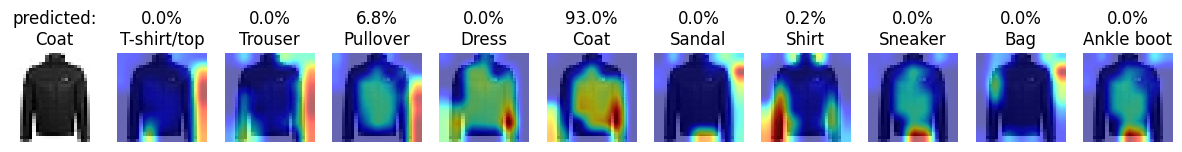

In [ ]:
# Your code here
plt.figure(figsize=(15, 3))
plt.subplot(1, num_classes + 1, 1)
plt.imshow(img_arr, cmap="Greys")
plt.axis("off")
plt.title(f"predicted:\n{predicted_class_name}")
for i in range(num_classes):
    target = [ClassifierOutputTarget(i)]
    cam_map = cam(input_tensor=img_t, targets=target).squeeze(0)

    plt.subplot(1, num_classes + 1, i + 2)
    #plt.figure(figsize=(3, 3))
    plt.imshow(img_arr, cmap="Greys")
    plt.imshow(cam_map, alpha=0.6, interpolation="bilinear", cmap="jet")
    plt.axis("off")
    plt.title(f"{prediction[0][i].item():.1%}\n{test_data.classes[i]}")

plt.show()

В цикле по всем изображениям в тензоре `images` повторите действия, с которыми вы получили визуализацию выше.

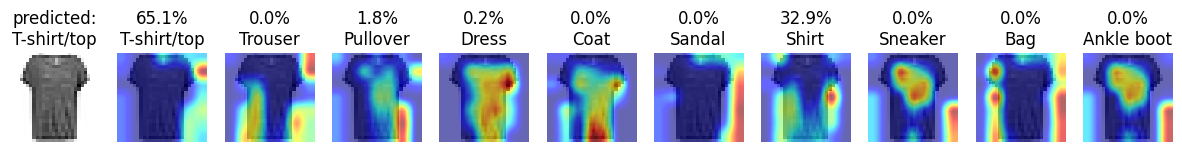

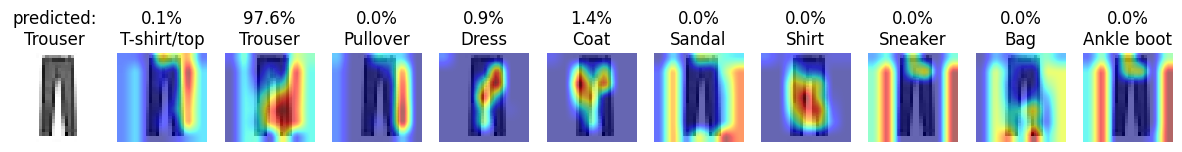

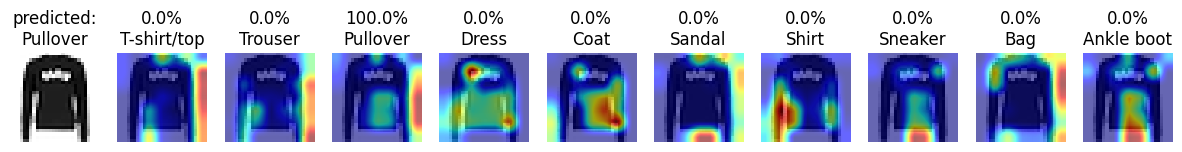

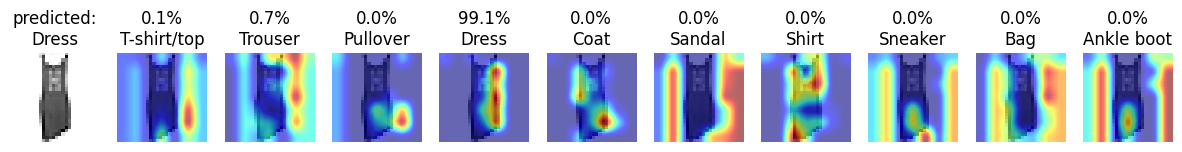

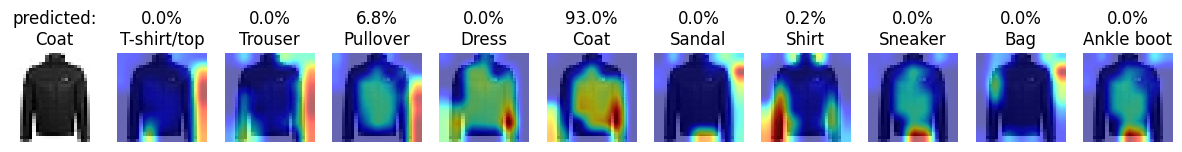

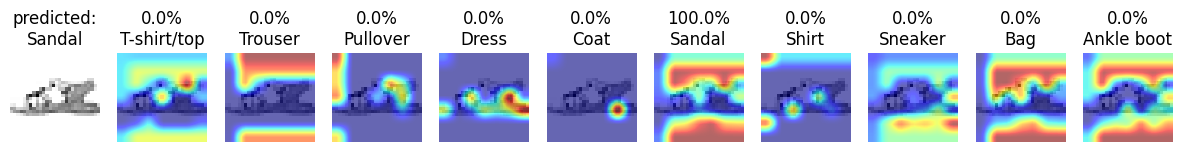

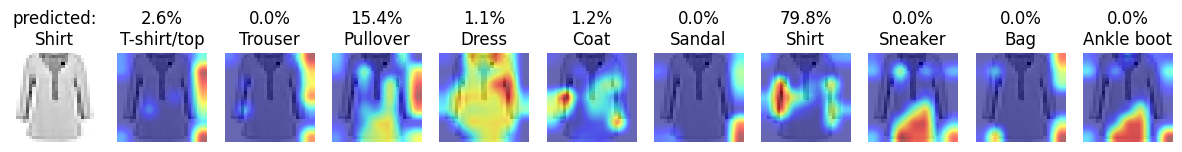

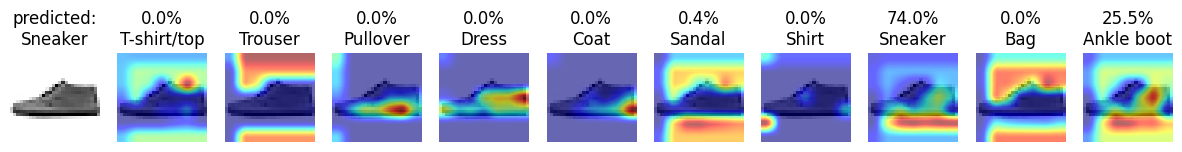

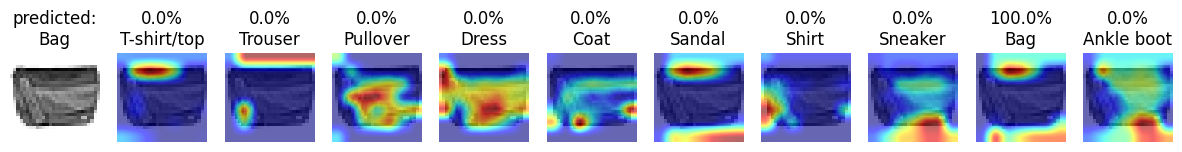

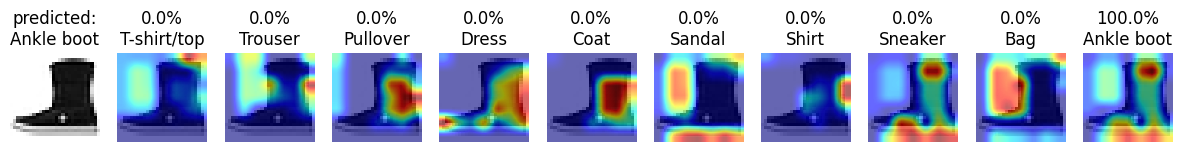

In [ ]:
# Your code here
for j in range(num_classes):
    plt.figure(figsize=(15, 3))
    img_t = images[j].unsqueeze(0)
    img_arr = images[j].numpy().squeeze(0)
    prediction = torch.nn.functional.softmax(model(img_t), dim=1)
    predicted_class = prediction.argmax()

    plt.subplot(1, num_classes + 1, 1)
    plt.imshow(img_arr, cmap="Greys")
    plt.axis("off")
    plt.title(f"predicted:\n{test_data.classes[j]}")

    for i in range(num_classes):
      target = [ClassifierOutputTarget(i)]
      cam_map = cam(input_tensor=img_t, targets=target).squeeze(0)

      plt.subplot(1, num_classes + 1, i + 2)
      #plt.figure(figsize=(3, 3))
      plt.imshow(images[j].squeeze(0), cmap="Greys")
      plt.imshow(cam_map, alpha=0.6, interpolation="bilinear", cmap="jet")
      plt.axis("off")
      plt.title(f"{prediction[0][i].item():.1%}\n{test_data.classes[i]}")
    plt.show()
plt.show()

Проанализируйте полученные результаты, опишите свои наблюдения и замечания:

***Your text here***
Интересное задание. Полученные и визуализированные GradCAM-карты активаций для сверточной нейронной сети, обученной на датасете FashionMNIST, вполне адекватны. Хотелось бы лучше различать футболку и рубашку (65% для футболки, можно лучше). Возможно, нужен более объемный датасет.


# Задание 4*. Adversarial attack

В прошлых заданиях мы писали **ResNet**, теперь попробуем его “сломать”. Будем изменять входное изображение, чтобы получать разные предсказания модели. Сначала изменим изображение, чтобы увеличить вероятность предсказываемого классса, а затем изменим изображение, чтобы модель предсказала класс, который не входил в топ-5 предсказаний на оригинальном изображении.

 Для этого нужно:
1. Скачать изображение и сохранить оригинальную картинку. Можно использовать изображение из лекции или скачать любое изображение из интернета.
**Совет:** *используйте `!wget`, это позволит воспроизвести код без ручной загрузки картинки (по крайней мере, пока ссылка на картинку будет доступна).*

2. Сделать предсказание с помощью предобученной ResNet18. Выбрать класс с максимальной вероятностью.

3. Довести вероятность максимально вероятного класса до 98% (сильно больше не нужно, т.к. при длительном обучении картинка может начать деградировать). Сохранить картинку с увеличенной вероятностью наиболее вероятного класса. Посчитать среднюю разницу между картинками.

**Совет:** *для изменения картинки можно использовать оптимизатор с флагом `maximize=True`.*

4. Выбрать класс, который не входит в топ-5. Довести его вероятность до 98%. Сохранить картинку с увеличенной вероятностью класса, который не входит в топ-5. Посчитать среднюю разницу между сохраненной и оригинальной картинкой.

5. Построить карты важности для оригинальной картинки, картинки с увеличенным основным классом и случайным классом двумя градиентными способами.

6. Сделать визуализацию, написать вывод.

**Общий совет:** градиентные методы, меняя значения пикселей, могут вывести их за границы от 0 до 1. Для восстановления диапазона можете использовать функцию `clip`. Финальные вероятности, разницы и объяснения имеет смысл делать для изображений после восстановления диапазона (возможно, вам придется денормализовать и нормализовать изображение).

## Формат результата
* Визуализация результата (картинка может отличаться).
<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/result_4_task_ex14.png" width="700">
* Средняя разница значений пикселей между исходным и модифицированным изображением.
* Вывод.


Загрузка модели и меток классов:

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/cat_and_dog1.jpg' -O cat_and_dog1.jpg
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX14/imagenet_class_index.json' -O imagenet_class_index.json

In [ ]:
import os
import json
import torch
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath("/content/imagenet_class_index.json"), "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    lable2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [ ]:
# Your code here

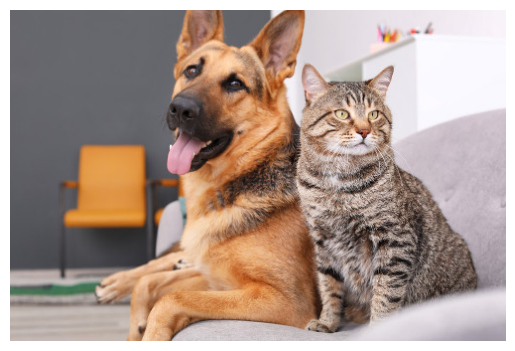

In [ ]:
from PIL import Image


def get_image(path):
    with open(os.path.abspath(path), "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB")


img = get_image("cat_and_dog1.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
from torchvision import transforms

# resize & normalize


def get_input_transform():
    transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ]
    )
    return transform


# for get croped img from input tensor


def get_reverse_transform():
    transform = transforms.Compose(
        [
            transforms.Normalize(
                mean=(0.0, 0.0, 0.0), std=(1 / 0.229, 1 / 0.224, 1 / 0.225)
            ),
            transforms.Normalize(
                mean=(-0.485, -0.456, -0.406),
                std=(1.0, 1.0, 1.0),
            ),
            transforms.Lambda(lambda x: torch.permute(x, (0, 2, 3, 1))),
            transforms.Lambda(lambda x: x.detach().numpy()),
        ]
    )
    return transform


def get_input_tensors(img):
    transform = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)


def get_crop_img(img_tensor):
    transform = get_reverse_transform()
    return transform(img_tensor)[0]

In [ ]:
import torch.nn.functional as F
img_t = get_input_tensors(img)

model.to(device)
model.eval()
logits_original = model(img_t.to(device))

def top_k_class(logits, k=15):
    prediction = F.softmax(logits, dim=1)
    top_props, top_inds = prediction.topk(k)

    for i in range(k):
        category_name = idx2label[top_inds[0][i].item()]
        score = top_props[0][i].item()
        print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")


top_k_class(logits_original)

German_shepherd 235: 40.3%
tabby 281: 9.5%
tiger_cat 282: 6.9%
Egyptian_cat 285: 2.7%
space_heater 811: 2.3%
malinois 225: 1.2%
Norwegian_elkhound 174: 1.0%
hamper 588: 0.9%
doormat 539: 0.9%
quilt 750: 0.9%
dumbbell 543: 0.7%
window_screen 904: 0.7%
tennis_ball 852: 0.7%
folding_chair 559: 0.6%
printer 742: 0.6%


In [ ]:
id_shepherd = 235
id_tennis_ball = 852

In [ ]:
img_t.requires_grad = True  # Tell pytorch to compute grads w.r.t. inputs too

top_score, top_idx = logits_original[0].topk(1)  # Get id of class with best score
id = top_idx[0].item()

print(id, idx2label[id])  # Print the label this class

score = logits_original[:, id]  # Model output for particular class

235 German_shepherd


In [ ]:
# Compute gradients
score.backward(retain_graph=True)

# retain_grad = True is not nessesary
# But if we run this code second time, we got a torch error without it
# because pytorch want to accumulate gradients explicitly

print(img_t.grad.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import numpy as np
from matplotlib import pylab as P


# Helper method to display grad
def grad_to_image(raw_grads, percentile=99):
    gradients = raw_grads.detach().cpu().numpy()
    gradients = np.transpose(gradients, (0, 2, 3, 1))[0]

    image_2d = np.sum(np.abs(gradients), axis=2)

    vmax = np.percentile(image_2d, percentile)
    vmin = np.min(image_2d)

    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)


def plot_saliency_map(img_tensor, saliency_map):
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.subplot(1, 2, 1)
    img = get_crop_img(img_t)
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap=P.cm.gray, vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

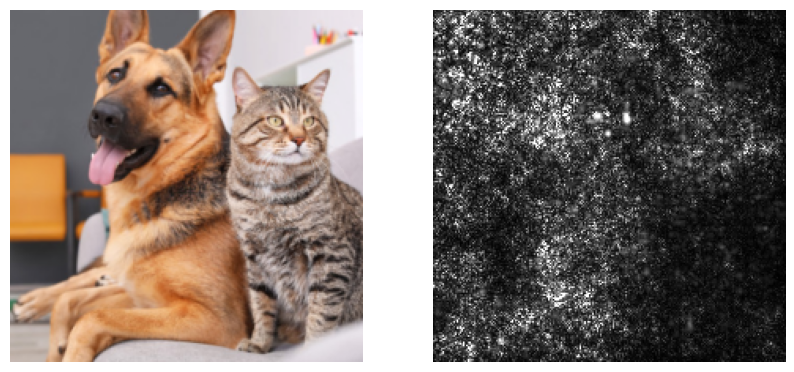

In [ ]:
saliency_map = grad_to_image(img_t.grad)
plot_saliency_map(img_t, saliency_map)

In [ ]:
img_t_98_shepherd = torch.tensor(img_t, requires_grad=True).detach()
img_t_98_shepherd.requires_grad = True
for param in model.parameters():
    param.requires_grad = True

optimizer =  torch.optim.Adam([img_t_98_shepherd], lr=1e-4, maximize=True)
for i in range(150):
    model.eval()
    logits_98_shepherd = model(img_t_98_shepherd.to(device))
    score = logits_98_shepherd[:, id_shepherd]
    score.backward(retain_graph=True)
    optimizer.step()
    prob = F.softmax(logits_98_shepherd, dim=1)
    optimizer.zero_grad()
    if prob[0][id_shepherd] > 0.985:
        break
    print(prob[0][id_shepherd])

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.4031, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4288, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4549, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.4811, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5071, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5328, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5582, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.5832, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6079, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6321, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.6785, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7007, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7219, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7421, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7612, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.7794, device='cuda:0', grad_fn=<SelectBackward0

In [ ]:
img_t_98_shepherd_detach = img_t_98_shepherd.squeeze().permute([1, 2, 0]).detach().numpy()

In [ ]:
img_t_98_shepherd_detach

array([[[-0.3673679 , -0.22814152,  0.08215687],
        [-0.3676302 , -0.2288017 ,  0.07719652],
        [-0.3660595 , -0.22806327,  0.08056776],
        ...,
        [ 1.9182427 ,  1.9708267 ,  2.313326  ],
        [ 1.9354444 ,  1.9937568 ,  2.331248  ],
        [ 1.9527564 ,  2.0034087 ,  2.3388932 ]],

       [[-0.3678813 , -0.22860578,  0.08123187],
        [-0.36743858, -0.22873078,  0.08130589],
        [-0.36665398, -0.23041858,  0.08076488],
        ...,
        [ 1.918062  ,  1.9679774 ,  2.3134809 ],
        [ 1.9356441 ,  1.9859941 ,  2.3314443 ],
        [ 1.9624296 ,  2.0137203 ,  2.3488677 ]],

       [[-0.3671051 , -0.22817667,  0.08228233],
        [-0.36934453, -0.23746923,  0.07862679],
        [-0.36975983, -0.23730953,  0.076058  ],
        ...,
        [ 1.9418371 ,  1.9890872 ,  2.3313959 ],
        [ 1.9352779 ,  1.9858769 ,  2.3310924 ],
        [ 1.9526647 ,  2.003432  ,  2.3470047 ]],

       ...,

       [[ 1.234173  ,  1.1316905 ,  1.2263231 ],
        [ 1

In [ ]:
img_t_98_shepherd_detach = (img_t_98_shepherd_detach - img_t_98_shepherd_detach.min()) / (img_t_98_shepherd_detach.max() - img_t_98_shepherd_detach.min())

In [ ]:
img_t_98_shepherd_detach

array([[[0.3528774 , 0.38278055, 0.44942668],
        [0.35282105, 0.38263875, 0.4483613 ],
        [0.3531584 , 0.38279736, 0.44908538],
        ...,
        [0.8437826 , 0.8550767 , 0.9286389 ],
        [0.8474772 , 0.8600016 , 0.93248826],
        [0.8511955 , 0.8620747 , 0.93413025]],

       [[0.35276714, 0.38268083, 0.449228  ],
        [0.3528622 , 0.38265398, 0.44924393],
        [0.35303074, 0.3822915 , 0.44912767],
        ...,
        [0.8437438 , 0.85446465, 0.92867225],
        [0.8475201 , 0.8583343 , 0.93253046],
        [0.85327315, 0.8642894 , 0.9362726 ]],

       [[0.35293382, 0.38277298, 0.44945362],
        [0.35245287, 0.38077715, 0.4486685 ],
        [0.35236368, 0.38081142, 0.44811675],
        ...,
        [0.84885025, 0.8589987 , 0.93252   ],
        [0.8474415 , 0.85830915, 0.9324549 ],
        [0.8511758 , 0.8620797 , 0.93587244]],

       ...,

       [[0.69685763, 0.67484635, 0.6951716 ],
        [0.6967647 , 0.6742364 , 0.694652  ],
        [0.6968721 , 0

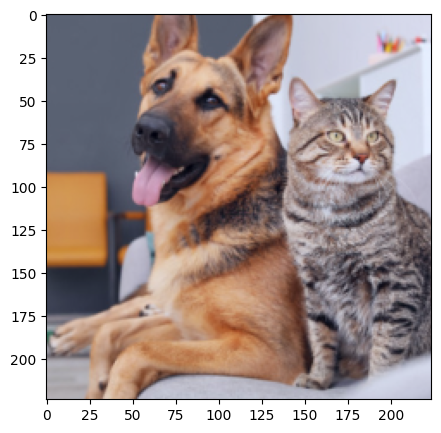

German_shepherd 235: 98.5%
malinois 225: 0.4%
Norwegian_elkhound 174: 0.2%
tabby 281: 0.1%
tiger_cat 282: 0.1%
Leonberg 255: 0.1%
bloodhound 163: 0.0%
Eskimo_dog 248: 0.0%
kelpie 227: 0.0%
Egyptian_cat 285: 0.0%
space_heater 811: 0.0%
dingo 273: 0.0%
malamute 249: 0.0%
Great_Dane 246: 0.0%
Rottweiler 234: 0.0%


In [ ]:
model = model.to(device)
model.eval()

plt.imshow(img_t_98_shepherd_detach)
plt.show()

top_k_class(logits_98_shepherd)

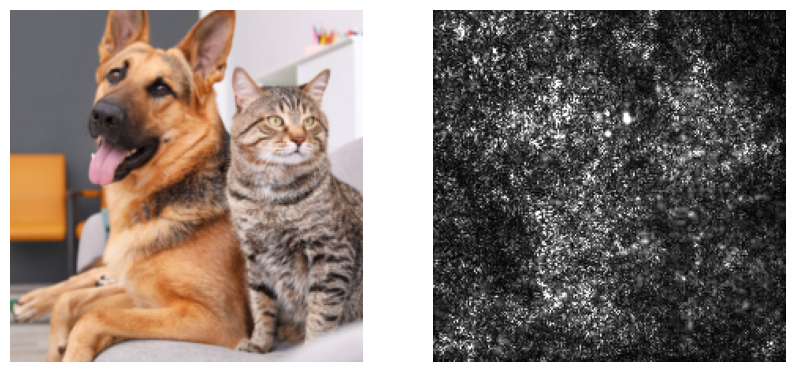

In [ ]:
saliency_map = grad_to_image(img_t_98_shepherd.grad)
plot_saliency_map(img_t_98_shepherd, saliency_map)

In [ ]:
for i in range(img_t.shape[0]):
  for j in range(img_t.shape[1]):
    for k in range(img_t.shape[2]):
      for l in range(img_t.shape[3]):
        dist_1 = img_t_98_shepherd[i][j][k][l]-img_t[i][j][k][l]
dist_1 = dist_1 / (img_t.shape[0] * img_t.shape[1] * img_t.shape[2] * img_t.shape[3])
print(dist_1)

tensor(-3.0753e-08, grad_fn=<DivBackward0>)


In [ ]:
img_t_98_tennis_ball = torch.tensor(img_t_98_shepherd, requires_grad=True).detach()
img_t_98_tennis_ball.requires_grad = True
for param in model.parameters():
    param.requires_grad = True

optimizer =  torch.optim.Adam([img_t_98_tennis_ball], lr=1e-4, maximize=True)
for i in range(15000):
    model.eval()
    logits_98_tennis_ball = model(img_t_98_tennis_ball.to(device))
    score = logits_98_tennis_ball[:, id_tennis_ball]
    score.backward(retain_graph=True)
    optimizer.step()
    prob = F.softmax(logits_98_tennis_ball, dim=1)
    optimizer.zero_grad()
    if prob[0][id_tennis_ball] > 0.985:
        break
    print(prob[0][id_tennis_ball])

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0

In [ ]:
img_t_98_tennis_ball_detach = img_t_98_tennis_ball.squeeze().permute([1, 2, 0]).detach().numpy()
img_t_98_tennis_ball_detach = (img_t_98_tennis_ball_detach - img_t_98_tennis_ball_detach.min()) / (img_t_98_tennis_ball_detach.max() - img_t_98_tennis_ball_detach.min())

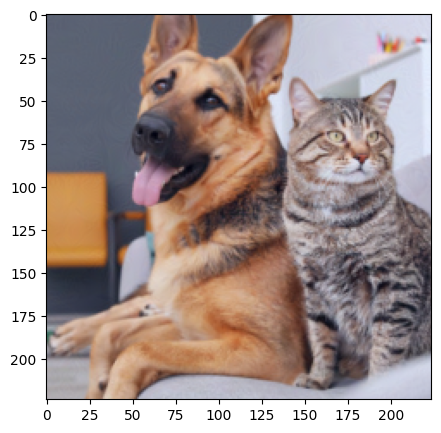

tennis_ball 852: 98.5%
German_shepherd 235: 1.4%
kelpie 227: 0.0%
dingo 273: 0.0%
malinois 225: 0.0%
Norwegian_elkhound 174: 0.0%
Cardigan 264: 0.0%
Eskimo_dog 248: 0.0%
muzzle 676: 0.0%
Pembroke 263: 0.0%
Siberian_husky 250: 0.0%
basenji 253: 0.0%
redbone 168: 0.0%
Chihuahua 151: 0.0%
golden_retriever 207: 0.0%


In [ ]:
model = model.to(device)
model.eval()

plt.imshow(img_t_98_tennis_ball_detach)
plt.show()

top_k_class(logits_98_tennis_ball)

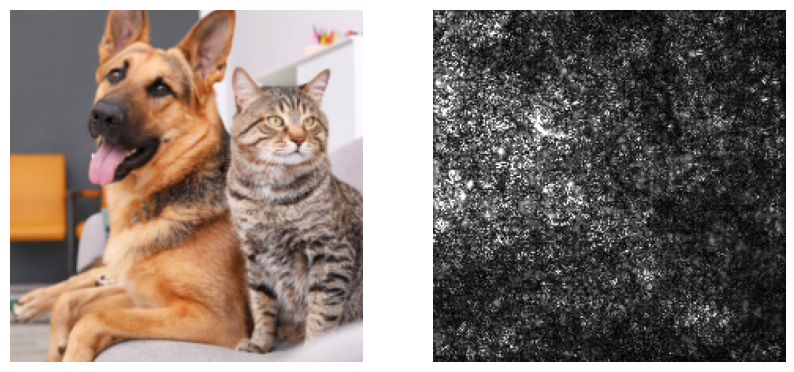

In [ ]:
saliency_map = grad_to_image(img_t_98_tennis_ball.grad)
plot_saliency_map(img_t_98_tennis_ball, saliency_map)

In [ ]:
for i in range(img_t.shape[0]):
  for j in range(img_t.shape[1]):
    for k in range(img_t.shape[2]):
      for l in range(img_t.shape[3]):
        dist_2 = img_t_98_tennis_ball[i][j][k][l]-img_t_98_shepherd[i][j][k][l]
dist_2 = dist_2 / (img_t.shape[0] * img_t.shape[1] * img_t.shape[2] * img_t.shape[3])
print(dist_2)

tensor(-1.8497e-07, grad_fn=<DivBackward0>)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.layer4[1].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


target_layers = [model.layer4[1].conv2] # Your code here

cam = GradCAM(model, target_layers) # Your code here

In [ ]:
top_props_original, top_inds_original = logits_original.topk(15)

In [ ]:
top_props_original

tensor([[8.6048, 7.1629, 6.8409, 5.8988, 5.7347, 5.1022, 4.8579, 4.8549, 4.8449,
         4.7677, 4.6143, 4.5774, 4.5354, 4.3924, 4.3505]], device='cuda:0',
       grad_fn=<TopkBackward0>)

In [ ]:
top_inds_original

tensor([[235, 281, 282, 285, 811, 225, 174, 588, 539, 750, 543, 904, 852, 559,
         742]], device='cuda:0')

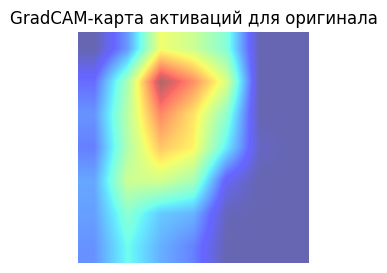

In [ ]:
target = [ClassifierOutputTarget(top_inds_original[0][0])] # Your code here
cam_map = cam(input_tensor=img_t, targets=target).squeeze(0) # Your code here

plt.figure(figsize=(3, 3))
plt.imshow(
    cam_map,
    alpha=0.6,
    interpolation="bilinear",
    cmap="jet",
    )
plt.axis("off")
plt.title('GradCAM-карта активаций для оригинала')
plt.show()

In [ ]:
top_props_98_shepherd, top_inds_98_shepherd = logits_98_shepherd.topk(15)

In [ ]:
top_inds_98_shepherd

tensor([[235, 225, 174, 281, 282, 255, 163, 248, 227, 285, 811, 273, 249, 246,
         234]], device='cuda:0')

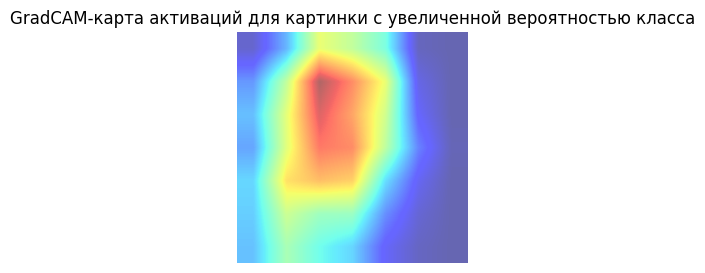

In [ ]:
target = [ClassifierOutputTarget(top_inds_98_shepherd[0][0])] # Your code here
cam_map = cam(input_tensor=img_t_98_shepherd, targets=target).squeeze(0) # Your code here

plt.figure(figsize=(3, 3))
plt.imshow(
    cam_map,
    alpha=0.6,
    interpolation="bilinear",
    cmap="jet",
    )
plt.axis("off")
plt.title('GradCAM-карта активаций для картинки с увеличенной вероятностью класса')
plt.show()

In [ ]:
top_props_98_tennis_ball, top_inds_98_tennis_ball = logits_98_tennis_ball.topk(15)

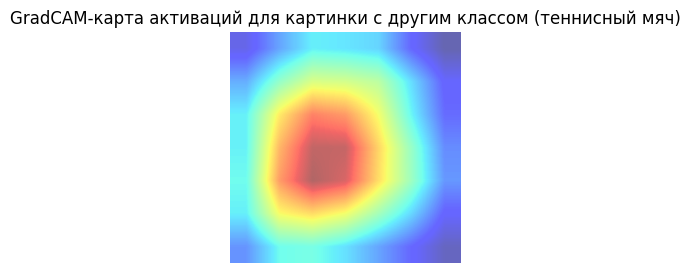

In [ ]:
target = [ClassifierOutputTarget(top_inds_98_tennis_ball[0][0])] # Your code here
cam_map = cam(input_tensor=img_t_98_tennis_ball, targets=target).squeeze(0) # Your code here

plt.figure(figsize=(3, 3))
plt.imshow(
    cam_map,
    alpha=0.6,
    interpolation="bilinear",
    cmap="jet",
    )
plt.axis("off")
plt.title('GradCAM-карта активаций для картинки с другим классом (теннисный мяч)')
plt.show()

**Напишите вывод:**
Интересное задание на порчу модели, чтобы при несущественных на взгляд изменениях картинки она выдавала разные классы. Интересно, могут ли этим пользоваться деятели от искусства, которые сейчас возмущаются, что генеративные модели и модели с трансфером стиля отнимут у них работу? Вроде как они сейчас научились как-то аугментировать свои работы, но это заметно, в отличие от нашего случая. Средняя разница между картинкой с максимизацией вероятности теннисного мяча и картинкой с максимизацией вероятности собаки больше, чем между последней и оригиналом. Немного не успел сделать красивый вывод изображений одной картинкой.